# SVC 

This document is dedicated to the testing of SVC models. 

In [1]:
import pandas as pd
# from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
import importlib
import sys 
# from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from xgboost import XGBClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler

sys.path.append("../")

from proj_mod import visualization, data_processing, training 
importlib.reload(visualization);
importlib.reload(data_processing);
importlib.reload(training); 

# from joblib import dump, load
import cloudpickle as cp

seed=420

In [2]:
df=pd.read_csv("../data/raw.csv")
df["y"]=df["y"].map({"no": 0, "yes": 1})
features=df.columns[:-1]
df_feat=df[features]
# df_feat["month_num"]=df_feat["month"].map({"jan":1, "feb":2, "mar":3, "apr":4, "may":5, "jun":6, "jul":7, "aug":8, "sep":9, "oct":10, "nov":11, "dec":12}).to_numpy().astype(int)
# df_feat["day_of_year"]=data_processing.day_of_non_leap_np(month_arr=df_feat["month_num"].to_numpy(), day_arr=df_feat["day"].to_numpy()).astype(int)
df_tar=df[["y"]]

## We first do it for the whole feature set 

In [8]:
SVC_base_linear=LinearSVC(
    dual="auto", 
    max_iter=5000, 
    class_weight="balanced"
)

pipe=Pipeline([
    ("data_transform", data_processing.data_transform()), 
    ("data_select", data_processing.data_selector(cut=0.98, how="mi score", mi_n_jobs=1)), 
    ("scaler", StandardScaler()),
    ("RFE", RFE(
        estimator=SVC_base_linear, 
        step=0.1
    )), 
    ("SVC", SVC(
        kernel="rbf",
        class_weight="balanced", 
        probability=True
    ))
])

param_dict= {
    "RFE__estimator__C": np.logspace(-1, 1, 5),

    "SVC__C":     np.logspace(-2, 2, 20),
    "SVC__gamma": np.logspace(-4, 0, 20)
}

SKF=StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
outer_split=list(SKF.split(X=df_feat, y=df_tar))

In [9]:
model_eval=training.model_eval(search_method="Random", search_cv_n_jobs=8)

In [10]:
model_eval.eval(df_feat=df_feat, df_tar=df_tar, pipe=pipe, outer_cv=outer_split, param_dict=param_dict)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [11]:
model_eval.save_dict("../data/fitted/svc/compressed_fitted_dict_svc_run1.gz", compress=True)

Data pickled
Data compressed
Fitted dictionary saved


In [12]:
model_eval.confusion_data_by_threshold(y=df_tar,outer_cv=outer_split)

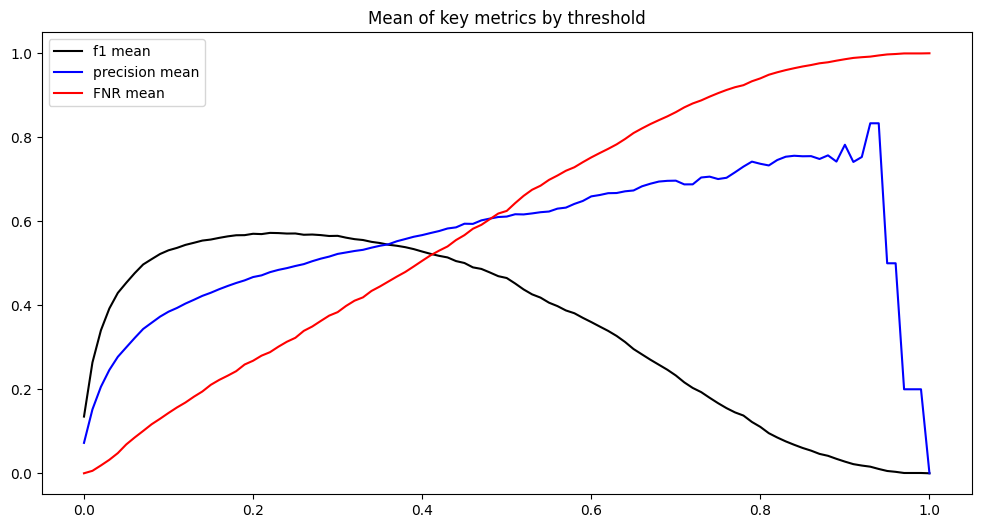

In [13]:
model_eval.create_visual()

In [14]:
model_eval.eval_metrics_

{'f1': np.float64(0.46488883655307334),
 'roc_auc': np.float64(0.9441176554441345),
 'ap': np.float64(0.5459849663698357)}

# We now do it for only the personal data features. 

In [3]:
SVC_base_linear=LinearSVC(
    dual="auto", 
    max_iter=5000, 
    class_weight="balanced"
)

pipe=Pipeline([
    ("data_transform", data_processing.data_transform(cam1=False, cam2=False)), 
    ("data_select", data_processing.data_selector(cut=0.98, how="mi score", mi_n_jobs=1)), 
    ("scaler", StandardScaler()),
    ("RFE", RFE(
        estimator=SVC_base_linear, 
        step=0.1
    )), 
    ("SVC", SVC(
        kernel="rbf",
        class_weight="balanced", 
        probability=True, 
        random_state=seed
    ))
])

param_dict= {
    "RFE__n_features_to_select": [0.6, 0.75, 0.9], 
    "RFE__estimator__C": np.logspace(-1, 1, 5),

    "SVC__C":     np.logspace(-2, 2, 20),
    "SVC__gamma": np.logspace(-4, 0, 20)
}

SKF=StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
outer_split=list(SKF.split(X=df_feat, y=df_tar))

In [4]:
model_eval_per=training.model_eval(search_method="Random", search_cv_n_jobs=8, random_search_n_iter=10, searech_verbose=3)

In [5]:
model_eval_per.eval(df_feat=df_feat, df_tar=df_tar, pipe=pipe, outer_cv=outer_split, param_dict=param_dict)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 4/5] END RFE__estimator__C=1.0, RFE__n_features_to_select=0.75, SVC__C=0.7847599703514611, SVC__gamma=0.05455594781168514; average_precision: (test=0.114) f1: (test=0.177) roc_auc: (test=0.611) total time= 2.9min
[CV 2/5] END RFE__estimator__C=1.0, RFE__n_features_to_select=0.75, SVC__C=0.7847599703514611, SVC__gamma=0.05455594781168514; average_precision: (test=0.105) f1: (test=0.173) roc_auc: (test=0.605) total time= 3.0min
[CV 3/5] END RFE__estimator__C=1.0, RFE__n_features_to_select=0.75, SVC__C=0.7847599703514611, SVC__gamma=0.05455594781168514; average_precision: (test=0.111) f1: (test=0.173) roc_auc: (test=0.611) total time= 3.1min
[CV 5/5] END RFE__estimator__C=1.0, RFE__n_features_to_select=0.75, SVC__C=0.7847599703514611, SVC__gamma=0.05455594781168514; average_precision: (test=0.100) f1: (test=0.170) roc_auc: (test=0.592) total time= 3.1min
[CV 1/5] END RFE__estimator__C=1.0, RFE__n_features_to_select=0.75, SVC

In [6]:
model_eval_per.save_dict("../data/fitted/svc/compressed_fitted_dict_per_svc_run1.gz", compress=True)

Data pickled
Data compressed
Fitted dictionary saved


In [7]:
model_eval_per.confusion_data_by_threshold(y=df_tar, outer_cv=outer_split)

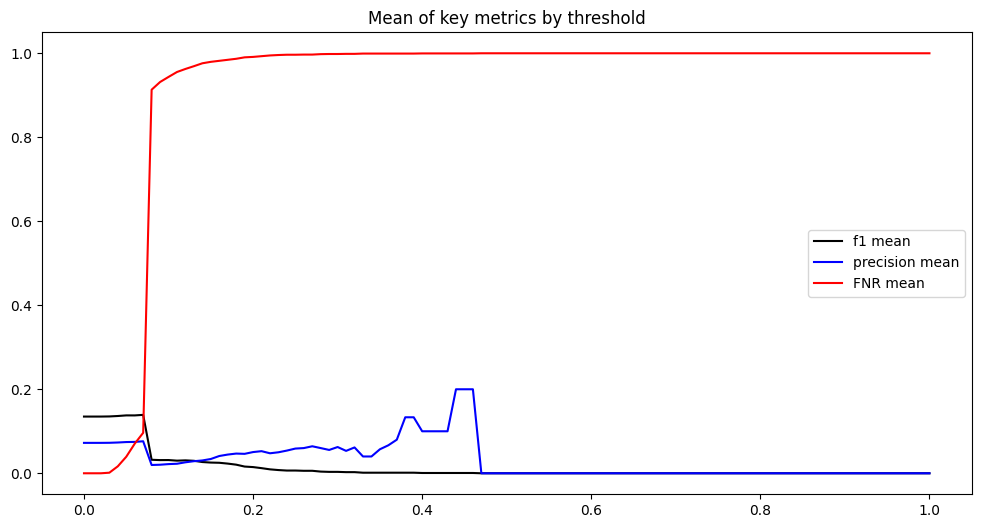

In [9]:
model_eval_per.create_visual()

In [10]:
model_eval_per.eval_metrics_

{'f1': np.float64(0.0),
 'roc_auc': np.float64(0.6132947919817704),
 'ap': np.float64(0.12746494852898443)}

The very definition of being useless. 